In [1]:
import json
import os
import sys
os.environ["PYSPARK_PYTHON"]='/opt/anaconda/envs/bd9/bin/python'
os.environ["SPARK_HOME"]='/usr/hdp/current/spark2-client'
os.environ["PYSPARK_SUBMIT_ARGS"]='--num-executors 3 --executor-memory 3G --driver-memory 4G --executor-cores 3 pyspark-shell'

spark_home = os.environ.get('SPARK_HOME', None)
if not spark_home:
    raise ValueError('SPARK_HOME environment variable is not set')

sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.7-src.zip'))
exec(open(os.path.join(spark_home, 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.7
      /_/

Using Python version 3.6.5 (default, Apr 29 2018 16:14:56)
SparkSession available as 'spark'.


In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark import Row
import json

conf = SparkConf()

spark = (SparkSession
         .builder
         .config(conf=conf)
         .appName("Lab3_by_sand")
         .getOrCreate())
spark

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
import re
import numpy as np
from sklearn.metrics import classification_report, precision_score
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, StopWordsRemover, IDF, CountVectorizer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, RegexTokenizer, MinMaxScaler, Normalizer
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier, LogisticRegression, MultilayerPerceptronClassifier
%matplotlib inline

In [4]:
TRAIN_FILE = "/labs/slaba03/laba03_train.csv"
TEST_FILE = "/labs/slaba03/laba03_test.csv"
ITEMS_FILE = "/labs/slaba03/laba03_items.csv"
VIEWS_FILE = "/labs/slaba03/laba03_views_programmes.csv"
RANDOM_SEED = 42

In [5]:
schema = StructType([StructField("user_id", IntegerType()),
                    StructField("item_id", IntegerType()),
                    StructField("purchase", DoubleType())])

In [6]:
lab03train = spark.read.csv(TRAIN_FILE, header=True, schema=schema)
lab03train.count()

5032624

In [7]:
lab03test = spark.read.csv(TEST_FILE, header=True, schema=schema)
lab03test.count()

2156840

In [8]:
lab03items = spark.read.csv(ITEMS_FILE, header=True, sep='\t')
lab03items.count()

635568

In [9]:
lab03items.groupBy("content_type").count().show()

+------------+------+
|content_type| count|
+------------+------+
|           0|631864|
|           1|  3704|
+------------+------+



In [10]:
lab03views = spark.read.csv(VIEWS_FILE, header=True)
lab03views.count()

20845607

### EDA

### Prepare dataframes

#### train and test 

In [11]:
lab03train = lab03train.withColumn("purchase", F.col("purchase").cast(IntegerType()))
lab03train.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- purchase: integer (nullable = true)



In [12]:
lab03test = lab03test.withColumn("purchase", F.col("purchase").cast(IntegerType())).repartition(3)
lab03test.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- purchase: integer (nullable = true)



In [13]:
lab03valid = lab03train.sampleBy("purchase", fractions={0: 0.2, 1: 0.2}, seed=RANDOM_SEED).repartition(3)
lab03train = lab03train.join(lab03valid, on=["user_id", "item_id"], how="leftanti").repartition(3)

In [14]:
lab03train.count(), lab03valid.count(), lab03test.count()

(4026457, 1006167, 2156840)

#### items

In [15]:
lab03items = lab03items.drop("datetime_availability_start",  "datetime_availability_stop", 
                             "datetime_show_start",  "datetime_show_stop", 
                             "channel_id", "region_id").filter(F.col("content_type") == '1') \
                    .drop("content_type").withColumn("year", F.col("year").cast(IntegerType()))
lab03items.printSchema()

root
 |-- item_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- genres: string (nullable = true)



In [16]:
lab03items.count()

3704

In [17]:
lab03items.filter(F.col("year").isNull()).count()

4

In [18]:
# Медиана слиском сложно - взять среднее
mean_year = lab03items.select(F.mean("year").cast(IntegerType()).alias("mean_year")).collect()[0]["mean_year"]
mean_year

2005

In [19]:
lab03items = lab03items.fillna(mean_year, subset=["year"]).withColumn("year", F.col("year").cast(IntegerType()))
lab03items.printSchema()

root
 |-- item_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- genres: string (nullable = true)



In [20]:
lab03items.filter(F.col("year").isNull()).count()

0

In [21]:
lab03items = lab03items.fillna("", subset=["genres"])

In [22]:
lab03items = lab03items.withColumn("genres_list", F.split(F.lower(F.col("genres")), pattern=','))

In [23]:
genres = lab03items.select("item_id", F.explode(F.col("genres_list")).alias("genre"))
genres.show(2)

+-------+-------+
|item_id|  genre|
+-------+-------+
|  65667|эротика|
|  65669|эротика|
+-------+-------+
only showing top 2 rows



In [24]:
genres_count = genres.join(lab03train, on="item_id").groupBy("genre").count()
genres_count.show(2)

+---------+-----+
|    genre|count|
+---------+-----+
|  мюзиклы|19547|
|кулинария| 1070|
+---------+-----+
only showing top 2 rows



In [25]:
genres_buy = genres.join(lab03train, on="item_id").groupBy("genre").sum("purchase")
genres_buy.show(2)

+---------+-------------+
|    genre|sum(purchase)|
+---------+-------------+
|  мюзиклы|           31|
|кулинария|            2|
+---------+-------------+
only showing top 2 rows



In [26]:
genres_stat = genres_count.join(genres_buy, on="genre") \
    .withColumnRenamed("sum(purchase)", "genre_buy") \
    .withColumnRenamed("count", "genre_cnt") \
    .withColumn("genre_prc", F.col("genre_buy") / F.col("genre_cnt"))
genres_stat.show(2)

+---------+---------+---------+--------------------+
|    genre|genre_cnt|genre_buy|           genre_prc|
+---------+---------+---------+--------------------+
|  мюзиклы|    19547|       31|0.001585921113214304|
|кулинария|     1070|        2|0.001869158878504673|
+---------+---------+---------+--------------------+
only showing top 2 rows



In [27]:
genres_encoding = {row.genre: row.genre_prc for row in genres_stat.collect()}
broadcasted_genres_encoding = spark.sparkContext.broadcast(genres_encoding)
genres_encoding

{'мюзиклы': 0.001585921113214304,
 'кулинария': 0.001869158878504673,
 'мультсериалы': 0.006148724394469545,
 'детские песни': 0.0025075887554441073,
 'боевики': 0.0026665044458638763,
 'фильмы в 3d': 0.0009000900090009,
 'аниме': 0.0032388663967611335,
 'арт-хаус': 0.0006137793463249962,
 ' сказка': 0.006940253470126735,
 'полнометражные': 0.0043754039384354924,
 'вестерн': 0.008253438932888704,
 'романтические': 0.0005010438413361169,
 'драма': 0.004491828119926399,
 'мелодрамы': 0.0013178179892861593,
 'экранизации': 0.0008254987388213712,
 'фэнтези': 0.002507118628685521,
 'музыкальные': 0.001556705279062314,
 'боевик': 0.0019984627209838584,
 'научная фантастика': 0.004939796233405372,
 'исторический': 0.004540295119182747,
 'игры': 0.0013836042891732965,
 'приключение': 0.00045871559633027525,
 'западные мультфильмы': 0.0020174533170685934,
 'фильмы': 0.0011181513231457323,
 'мультфильмы в 3d': 0.008984725965858042,
 'для взрослых': 0.002372139629046441,
 'артхаус': 0.00254596888

In [28]:
lab03items.show(2, vertical=True, truncate=False)

-RECORD 0---------------------------------------------------------------
 item_id     | 65667                                                    
 title       | на пробах только девушки (all girl auditions)            
 year        | 2013                                                     
 genres      | Эротика                                                  
 genres_list | [эротика]                                                
-RECORD 1---------------------------------------------------------------
 item_id     | 65669                                                    
 title       | скуби ду: эротическая пародия (scooby doo: a xxx parody) 
 year        | 2011                                                     
 genres      | Эротика                                                  
 genres_list | [эротика]                                                
only showing top 2 rows



In [29]:
from pyspark.ml.linalg import Vectors, VectorUDT
@F.udf(VectorUDT())
def genre_encoder(arr):
    encoding = broadcasted_genres_encoding.value
    all_genres = list(encoding.keys())
    return Vectors.dense([encoding[genre] if genre in arr else 0 for genre in all_genres])
lab03items.select("item_id", "genres_list", genre_encoder(F.col("genres_list"))) \
    .show(2, vertical=True, truncate=False)

-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 item_id                    | 65667                                                                                                                                                                                                                                                                                                                                                               
 genres_list                | [эротика]                                                                                                                                                                                           

In [30]:
genres = genres.join(genres_stat, on="genre")
genres.show(2)

+-------+-------+---------+---------+--------------------+
|  genre|item_id|genre_cnt|genre_buy|           genre_prc|
+-------+-------+---------+---------+--------------------+
|мюзиклы|  93623|    19547|       31|0.001585921113214304|
|мюзиклы|  93637|    19547|       31|0.001585921113214304|
+-------+-------+---------+---------+--------------------+
only showing top 2 rows



In [31]:
lab03items = lab03items.drop("genres").join(
    lab03items.join(genres, on="item_id", how="left").groupBy("item_id").agg(
        F.collect_list("genre").alias("genres"),
        F.sum("genre_cnt").alias("genres_cnt"),
        F.sum("genre_buy").alias("genres_buy"),
        F.sum("genre_prc").alias("genres_prc")
    ), on="item_id") \
    .fillna(0, subset=["genres_cnt", "genres_buy", "genres_prc"]) \
    .withColumn("genres_enc", genre_encoder(F.col("genres_list")))
lab03items.show(2, vertical=True, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 item_id     | 100140                                                                                                                                                                                                                                                                                                                                                                                                                                    
 title       | поездка                                                                                              

In [32]:
pca = PCA(k=3, inputCol="genres_enc", outputCol="genres_pca")
pca_model = pca.fit(lab03items)
lab03items = pca_model.transform(lab03items)

In [33]:
lab03items.show(2, vertical=True, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 item_id     | 100140                                                                                                                                                                                                                                                                                                                                                                                                                                    
 title       | поездка                                                                                              

In [34]:
SECS_IN_DAY = 24 * 60 * 60
lab03views = lab03views.withColumn("duration",  F.col("ts_end") - F.col("ts_start"))
view_live_stats = lab03views.filter(F.col("item_type") == "live").groupBy("user_id").agg(
    F.min(F.col("duration")).cast(IntegerType()).alias("live_min_duration"),
    F.max(F.col("duration")).cast(IntegerType()).alias("live_max_duration"),
    F.log(F.mean(F.col("duration"))).cast(DoubleType()).alias("live_mean_duration"),
    F.sum(F.col("duration")).cast(IntegerType()).alias("live_sum_duration"),
    F.count("*").alias("live_counts"))
view_pvr_stats = lab03views.filter(F.col("item_type") == "pvr").groupBy("user_id").agg(
    F.min(F.col("duration")).cast(IntegerType()).alias("pvr_min_duration"),
    F.max(F.col("duration")).cast(IntegerType()).alias("pvr_max_duration"),
    F.mean(F.col("duration")).cast(IntegerType()).alias("pvr_mean_duration"),
    F.sum(F.col("duration")).cast(IntegerType()).alias("pvr_sum_duration"),
    F.count("*").alias("pvr_counts")) 
view_live_stats.show(2, vertical=True, truncate=False)
view_pvr_stats.show(2, vertical=True, truncate=False)

-RECORD 0-------------------------------
 user_id            | 775072            
 live_min_duration  | 303               
 live_max_duration  | 36646             
 live_mean_duration | 9.106068465446302 
 live_sum_duration  | 639696            
 live_counts        | 71                
-RECORD 1-------------------------------
 user_id            | 776228            
 live_min_duration  | 304               
 live_max_duration  | 7029              
 live_mean_duration | 7.547416806037808 
 live_sum_duration  | 164938            
 live_counts        | 87                
only showing top 2 rows

-RECORD 0-------------------
 user_id           | 775072 
 pvr_min_duration  | 495    
 pvr_max_duration  | 9917   
 pvr_mean_duration | 3037   
 pvr_sum_duration  | 288572 
 pvr_counts        | 95     
-RECORD 1-------------------
 user_id           | 777985 
 pvr_min_duration  | 816    
 pvr_max_duration  | 1509   
 pvr_mean_duration | 1162   
 pvr_sum_duration  | 2325   
 pvr_counts        | 2  

In [35]:
user_watches = lab03train.groupBy('user_id').agg(F.count("*").alias("user_watches_count"), 
                                                 F.sum("purchase").alias("user_purchase_count")) \
    .withColumn("user_buy_percent", F.col("user_purchase_count") / F.col("user_watches_count")) 
user_watches.show(2)

+-------+------------------+-------------------+--------------------+
|user_id|user_watches_count|user_purchase_count|    user_buy_percent|
+-------+------------------+-------------------+--------------------+
| 833685|              1994|                 15|0.007522567703109328|
| 846231|              2071|                  4|0.001931434089811685|
+-------+------------------+-------------------+--------------------+
only showing top 2 rows



In [36]:
item_watches = lab03train.groupBy('item_id').agg(F.count("*").alias("item_watches_count"), 
                                                 F.sum("purchase").alias("item_purchase_count")) \
    .withColumn("item_buy_percent", F.col("item_purchase_count") / F.col("item_watches_count")) 
item_watches.show(2)

+-------+------------------+-------------------+--------------------+
|item_id|item_watches_count|item_purchase_count|    item_buy_percent|
+-------+------------------+-------------------+--------------------+
|  93486|              1120|                  3|0.002678571428571...|
|  90019|              1056|                  1| 9.46969696969697E-4|
+-------+------------------+-------------------+--------------------+
only showing top 2 rows



### Join all 

In [37]:
train_data = lab03train.join(lab03items, on="item_id") \
    .join(view_live_stats, on=["user_id"], how='left') \
    .join(view_pvr_stats, on=["user_id"], how='left') \
    .join(user_watches, on="user_id", how='left') \
    .join(item_watches, on="item_id", how='left') \
    .fillna(0, subset=view_live_stats.columns) \
    .fillna(0, subset=view_pvr_stats.columns) \
    .withColumn("user_items", F.log(F.col("item_purchase_count") * F.col("user_purchase_count") + F.lit(1)))
train_data.show(2, vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 item_id             | 8389                                                                                                                                                                                                                                                                                                                                                                                                                   
 user_id             | 754230                                                                                                             

In [38]:
valid_data = lab03valid.join(lab03items, on="item_id") \
    .join(view_live_stats, on=["user_id"], how='left') \
    .join(view_pvr_stats, on=["user_id"], how='left') \
    .join(user_watches, on="user_id", how='left') \
    .join(item_watches, on="item_id", how='left') \
    .fillna(0, subset=view_live_stats.columns) \
    .fillna(0, subset=view_pvr_stats.columns) \
    .withColumn("user_items", F.log(F.col("item_purchase_count") * F.col("user_purchase_count") + F.lit(1)))
valid_data.show(2, vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 item_id             | 8389                                                                                                                                                                                                                                                                                                                                                                                                                   
 user_id             | 795620                                                                                                             

In [39]:
test_data = lab03test.join(lab03items, on="item_id") \
    .join(view_live_stats, on=["user_id"], how='left') \
    .join(view_pvr_stats, on=["user_id"], how='left') \
    .join(user_watches, on="user_id", how='left') \
    .join(item_watches, on="item_id", how='left') \
    .fillna(0, subset=view_live_stats.columns) \
    .fillna(0, subset=view_pvr_stats.columns) \
    .withColumn("user_items", F.log(F.col("item_purchase_count") * F.col("user_purchase_count") + F.lit(1)))
test_data.show(2, vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 item_id             | 8389                                                                                                                                                                                                                                                                                                                                                                                                                   
 user_id             | 761341                                                                                                             

In [40]:
NUM_EXECUTORS = spark.sparkContext.getConf().get("spark.executor.instances")
int(NUM_EXECUTORS)

3

In [41]:
#Coalesce dataframe partitions from 200 to 3 * num_executors
train_data = train_data.repartition(int(NUM_EXECUTORS) * 3)
valid_data = valid_data.repartition(int(NUM_EXECUTORS) * 3)
test_data = test_data.repartition(int(NUM_EXECUTORS) * 3)

In [42]:
assert train_data.count() == lab03train.count()
assert valid_data.count() == lab03valid.count()
assert test_data.count() == lab03test.count()

### Prepare features

In [43]:
stop_words_ru = StopWordsRemover.loadDefaultStopWords("russian")
stop_words_en = StopWordsRemover.loadDefaultStopWords("english")
stop_words = [*stop_words_ru, *stop_words_en]

In [44]:
# трасформеры для текста
tokenizer = RegexTokenizer(inputCol="title", outputCol="words", pattern="\\s")
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="words_filtered", stopWords=stop_words)
tf = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="tf", ).setNumFeatures(2000)
idf = IDF(inputCol=tf.getOutputCol(), outputCol="idf", )
pca = PCA(k=3, inputCol=idf.getOutputCol(), outputCol="pca")
text_pipeline = Pipeline(stages=[tokenizer, swr, tf, idf, pca])

In [45]:
train_data.columns

['item_id',
 'user_id',
 'purchase',
 'title',
 'year',
 'genres_list',
 'genres',
 'genres_cnt',
 'genres_buy',
 'genres_prc',
 'genres_enc',
 'genres_pca',
 'live_min_duration',
 'live_max_duration',
 'live_mean_duration',
 'live_sum_duration',
 'live_counts',
 'pvr_min_duration',
 'pvr_max_duration',
 'pvr_mean_duration',
 'pvr_sum_duration',
 'pvr_counts',
 'user_watches_count',
 'user_purchase_count',
 'user_buy_percent',
 'item_watches_count',
 'item_purchase_count',
 'item_buy_percent',
 'user_items']

In [46]:
# трасформеры для числовых фичей
num_features = [
 'year',
 'genres_buy',
 'genres_prc',
 'live_min_duration',
 'live_max_duration',
 'live_mean_duration',
 'live_sum_duration',
 'live_counts',
 'pvr_min_duration',
 'pvr_max_duration',
 'pvr_mean_duration',
 'pvr_sum_duration',
 'pvr_counts',
 'user_purchase_count',
 'user_buy_percent',
 'item_purchase_count',
 'item_buy_percent',
# 'user_items',
]
num_features = VectorAssembler(inputCols=num_features, outputCol="num_features")
scaler = StandardScaler(inputCol=num_features.getOutputCol(), outputCol="scaled_features")
normalizer = Normalizer(inputCol=num_features.getOutputCol(), outputCol="normed_features")
num_pipeline = Pipeline(stages=[num_features])

In [47]:
all_assemble = VectorAssembler(inputCols=["genres_pca", text_pipeline.getStages()[-1].getOutputCol(),
                                          num_pipeline.getStages()[-1].getOutputCol()], outputCol="features")
preprocessing = Pipeline(stages=[text_pipeline, num_features, all_assemble])
preprocessing.getStages()

[Pipeline_ffaebca61cf2,
 VectorAssembler_b49847e137fe,
 VectorAssembler_66b6ee8528aa]

In [48]:
#preprocessing = num_pipeline

In [49]:
preprocessing_model = preprocessing.fit(train_data)
train = preprocessing_model.transform(train_data)
train.show(1, vertical=True, truncate=40)
valid = preprocessing_model.transform(valid_data)
valid.show(1, vertical=True, truncate=40)
test = preprocessing_model.transform(test_data)
test.show(1, vertical=True, truncate=40)

-RECORD 0-------------------------------------------------------
 item_id             | 90019                                    
 user_id             | 924175                                   
 purchase            | 0                                        
 title               | гнев                                     
 year                | 2014                                     
 genres_list         | [детективы, триллеры, боевики, зарубе... 
 genres              | [боевики, триллеры, детективы, зарубе... 
 genres_cnt          | 3581714                                  
 genres_buy          | 8004                                     
 genres_prc          | 0.008871372830513122                     
 genres_enc          | [0.0,0.0,0.0,0.0,0.002666504445863876... 
 genres_pca          | [0.0029916975858536596,-0.00125196984... 
 live_min_duration   | 315                                      
 live_max_duration   | 32837                                    
 live_mean_duration  | 8.

### Underfit

In [50]:
# underfit_data = preprocessed_train_data.sampleBy("purchase", fractions={0: 0.02, 1: 1}, seed=RANDOM_SEED)
# train, valid = preprocessed_train_data.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

### Split train/validate

In [51]:
#train = preprocessed_train_data.sampleBy("purchase", fractions={0: 0.8, 1: 0.8}, seed=RANDOM_SEED)

In [52]:
#valid = preprocessed_train_data.join(train, on=["user_id", "item_id"], how="leftanti")

In [53]:
#train, valid = preprocessed_train_data.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

### Base model (LogReg)

Accuracy is 0.9977369561911691
             precision    recall  f1-score   support

          0       1.00      1.00      1.00   1003986
          1       0.30      0.03      0.06      2181

avg / total       1.00      1.00      1.00   1006167

ROC on test data 0.8869973622601101


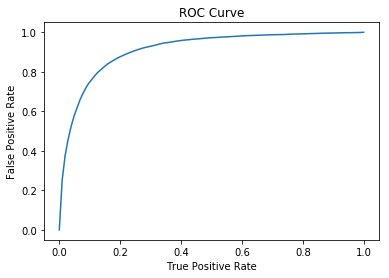

Training set areaUnderROC: 0.9114376019129553


In [54]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol="features", labelCol="purchase", maxIter=15)
lr_model = lr.fit(train)
predictions = lr_model.transform(valid)
correct_predictions = predictions.select("purchase", F.col("prediction").cast("int")) \
    .filter("purchase == prediction").count()
all_predictions = predictions.count()
print("Accuracy is {}".format(correct_predictions / all_predictions))
predictions_pd = predictions.select("purchase", F.col("prediction").cast("int")).toPandas()
print(classification_report(predictions_pd.purchase, predictions_pd.prediction))
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", 
                                          labelCol="purchase", metricName='areaUnderROC')
print("ROC on test data", evaluator.evaluate(predictions))
trainingSummary = lr_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [55]:
evaluator.evaluate(lr_model.transform(train))

0.9118640137923717

### GBTClassifier

In [70]:
gbt = GBTClassifier(featuresCol="features", labelCol="purchase", seed=RANDOM_SEED, maxBins=200)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability", 
                                          labelCol="purchase", metricName='areaUnderROC')
gbt_model = gbt.fit(train)
predictions = gbt_model.transform(valid)
correct_predictions = predictions.select("purchase", F.col("prediction").cast("int")) \
    .filter("purchase == prediction").count()
all_predictions = predictions.count()
print("Accuracy is {}".format(correct_predictions / all_predictions))
predictions_pd = predictions.select("purchase", F.col("prediction").cast("int")).toPandas()
print(classification_report(predictions_pd.purchase, predictions_pd.prediction))
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", 
                                          labelCol="purchase", metricName='areaUnderROC')
print("ROC on test data", evaluator.evaluate(predictions))

Accuracy is 0.9978373371418462
             precision    recall  f1-score   support

          0       1.00      1.00      1.00   1003986
          1       0.59      0.01      0.02      2181

avg / total       1.00      1.00      1.00   1006167

ROC on test data 0.8891158311562504


In [57]:
# Test for overfitting
evaluator.evaluate(gbt_model.transform(train))

0.9413510866488475

In [58]:
train_all = train.unionAll(valid).repartition(int(NUM_EXECUTORS) * 3)
train_all.rdd.getNumPartitions()

9

In [59]:
# paramGrid = ParamGridBuilder().addGrid(gbt.maxIter, [10, 15]) \
#                               .addGrid(gbt.maxDepth, [5, 7]) \
#                               .addGrid(gbt.stepSize, [0.1, 0.5]) \
#                               .build()
# crossval = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid,
#                               evaluator=evaluator, numFolds=3, parallelism=3)
# cv_model = crossval.fit(train_all)
# cv_model.avgMetrics

In [60]:
#print(cv_model.bestModel.explainParams())

In [61]:
# correct_predictions = predictions.select("purchase", F.col("prediction").cast("int")) \
#     .filter("purchase == prediction").count()
# all_predictions = predictions.count()
# print("Accuracy is {}".format(correct_predictions / all_predictions))
# predictions_pd = predictions.select("purchase", F.col("prediction").cast("int")).toPandas()
# print(classification_report(predictions_pd.purchase, predictions_pd.prediction))
# evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", 
#                                           labelCol="purchase", metricName='areaUnderROC')
# print("ROC on test data", evaluator.evaluate(predictions))

### Train on all trainset

In [62]:
gbt = GBTClassifier(featuresCol="features", labelCol="purchase", seed=RANDOM_SEED)
gbt_model = gbt.fit(train_all)
result = gbt_model.transform(test)

### Convert predictions

In [63]:
home_dir = os.environ['HOME']
vector_udf = F.udf(lambda vector: vector.toArray().tolist(), ArrayType(DoubleType()))
rows = result.select("user_id", "item_id", "probability") \
    .withColumn("purchase", vector_udf(F.col("probability"))[1]) \
    .drop("probability") \
    .sort(F.col("user_id").asc(), F.col("item_id").asc()) \
    .collect()

In [64]:
from tqdm import tqdm
with open(f"{home_dir}/lab03.csv", "wt") as file:
    row_count = len(rows)
    file.write(",user_id,item_id,purchase\n")
    for i, row in tqdm(zip(range(row_count), rows)):
        file.write(f"{i},{row.user_id},{row.item_id},{row.purchase}\n")

2156840it [00:12, 168710.94it/s]


In [65]:
#spark.stop()

In [66]:
!ls -l ~

total 86988
-rw-rw-r-- 1 andrey.sorokin andrey.sorokin      161 Oct 30 16:26 lab01.json
-rw-rw-r-- 1 andrey.sorokin andrey.sorokin   684644 Oct 30 16:30 lab02.json
-rw-r--r-- 1 andrey.sorokin andrey.sorokin 87182372 Nov  7 05:46 lab03.csv
-rw-r--r-- 1 andrey.sorokin andrey.sorokin  1189758 Oct 30 17:08 lab05.csv
drwxrwxr-x 6 andrey.sorokin andrey.sorokin     4096 Nov  7 00:02 sber-spark-ds-10
drwxrwxr-x 6 andrey.sorokin andrey.sorokin     4096 Nov  5 11:54 spark4ml


In [67]:
!head ~/lab03.csv

,user_id,item_id,purchase
0,1654,336,0.04405584327219747
1,1654,678,0.04405584327219747
2,1654,691,0.04405584327219747
3,1654,696,0.04438229931109838
4,1654,763,0.04405584327219747
5,1654,795,0.04833115594665793
6,1654,861,0.04405584327219747
7,1654,1137,0.04438229931109838
8,1654,1159,0.04405584327219747
